# The-Cost-of-Democracy
Asmaa Abdul-Amin<br>
CRN#: 40397  
Date: 1 August 2025 

## How has the last election cycle affected the cost of average grocery store items?:
- Fetches historical prices for Ground Beef, Sugar, and Eye Drops from Google Shopping and fallback web results.
- Computes changes from 2024 to the current year.
- Saves results to CSV and plots for visualization.


In [42]:
!pip install serpapi
!pip install google-search-results
!pip install python-dotenv

In [53]:
#!/usr/bin/env python3
"""
Asmaa Abdul-Amin
CRN#: 40397
25 July 2025

SerpApi-based price estimation with Google Shopping → Web fallback,
per-item bounds, and median aggregation.

In this analysis, I will:
- Fetch prices for Sugar, Ground Beef and Eye Drops from 2016, 2024, and the current year.
- Calculate price changes from 2024 to the current year.
- Save results to CSV and generate plots.

Outputs:
- CSV to asmaa/data/price_changes_serpapi_min.csv
- Plots to asmaa/plots/

Cycles computed & printed:
- 2024 → today (current year)
"""

import os
import re
import time
from datetime import datetime
from statistics import median
from typing import List, Dict, Optional

import pandas as pd
import matplotlib.pyplot as plt
from serpapi import GoogleSearch
from dotenv import load_dotenv

# -------------------- ENV & PATHS --------------------
load_dotenv()
API_KEY = os.getenv("SERPAPI_KEY") or os.getenv("API_KEY")
if not API_KEY:
    raise ValueError("Missing SERPAPI_KEY (or API_KEY) in environment / .env")

BASE_DIR = "The-Cost-of-Democracy/asmaa"
PLOTS_DIR = os.path.join(BASE_DIR, "plots")
DATA_DIR = os.path.join(BASE_DIR, "data")
os.makedirs(PLOTS_DIR, exist_ok=True)
os.makedirs(DATA_DIR, exist_ok=True)

THROTTLE = 1.0  # seconds between SerpApi calls

# -------------------- ITEMS & SITES --------------------
high_yield_sites = ["walmart.com", "target.com", "amazon.com", "instacart.com"]

# Minimal set per your latest message
ITEMS_SITES: List[tuple] = [
    ("Sugar", "price of Sugar, white, per lb", high_yield_sites),
    ("Ground_Beef", "price of ground beef per pound", high_yield_sites),
    ("Eye_Drops", "price of Pataday eye drops", high_yield_sites),
]

ITEM_RULES: Dict[str, Dict] = {
    "Sugar":   {"min": 3.00, "max": 15.00, "terms": ["Lb", "Pound", "lbs", "pounds"]},
    "Ground_Beef":  {"min": 5.00, "max": 50.00, "terms": ["Lb", "Pound"]},
    "Eye_Drops":    {"min": 3.00, "max": 50.00, "terms": []},
}

# -------------------- SerpApi helpers --------------------
def extract_prices_from_text(txt: str) -> List[float]:
    if not txt:
        return []
    matches = re.findall(r"\$?\s*(\d{1,3}(?:,\d{3})*(?:\.\d{2})?)", txt)
    vals: List[float] = []
    for m in matches:
        try:
            vals.append(float(m.replace(",", "")))
        except ValueError:
            pass
    return vals

def fetch_prices_shopping(query: str) -> List[float]:
    params = {"engine": "google_shopping", "q": query, "api_key": API_KEY, "num": 10}
    try:
        res = GoogleSearch(params).get_dict()
        out: List[float] = []
        for r in res.get("shopping_results", []):
            price_field = r.get("price")
            if isinstance(price_field, str):
                out.extend(extract_prices_from_text(price_field))
            elif isinstance(price_field, (int, float)):
                out.append(float(price_field))
        return out
    except Exception as e:
        print(f"[shopping error] {query}: {e}")
        return []

def fetch_prices_web(query: str) -> List[float]:
    params = {"engine": "google", "q": query, "api_key": API_KEY}
    try:
        res = GoogleSearch(params).get_dict()
        snippet = res.get("organic_results", [{}])[0].get("snippet", "") or ""
        return extract_prices_from_text(snippet)
    except Exception as e:
        print(f"[web error] {query}: {e}")
        return []

def get_year_price(item_key: str, base_query: str, year: str, sites: List[str]) -> Optional[float]:
    rules = ITEM_RULES.get(item_key, {"min": 0.5, "max": 100.0, "terms": []})
    terms_suffix = " ".join(rules.get("terms", []))
    collected: List[float] = []

    # Shopping per-site
    for site in sites:
        q = f"{base_query} {terms_suffix} price in {year} USA site:{site}".strip()
        collected.extend(fetch_prices_shopping(q))
        time.sleep(THROTTLE)

    # Shopping general
    if not collected:
        q = f"{base_query} {terms_suffix} price in {year} USA".strip()
        collected.extend(fetch_prices_shopping(q))

    # Web per-site
    if not collected:
        for site in sites:
            q = f"{base_query} {terms_suffix} price in {year} USA site:{site}".strip()
            collected.extend(fetch_prices_web(q))
            time.sleep(THROTTLE)

    # Web general
    if not collected:
        q = f"{base_query} {terms_suffix} price in {year} USA".strip()
        collected.extend(fetch_prices_web(q))

    lo, hi = rules["min"], rules["max"]
    bounded = [p for p in collected if lo <= p <= hi]
    if not bounded:
        return None
    return round(median(bounded), 2)

# -------------------- Build minimal table (2024 → current) --------------------
def build_serp_tables_2024_to_current(items_sites: List[tuple]) -> pd.DataFrame:
    current_year = str(datetime.now().year)
    rows = []

    def pct(a, b):
        if a is None or b is None or a == 0:
            return None
        return round(((b - a) / a) * 100, 1)

    def r2(v):
        return round(v, 2) if v is not None else None

    for item_key, query_base, sites in items_sites:
        print(f"\nFetching prices for: {item_key}")
        p2016 = get_year_price(item_key, query_base, "2016", sites); time.sleep(THROTTLE)
        p2024 = get_year_price(item_key, query_base, "2024", sites); time.sleep(THROTTLE)
        pNOW  = get_year_price(item_key, query_base, current_year, sites); time.sleep(THROTTLE)

        rows.append({
            "Item": item_key,
            "2016 Price ($)": r2(p2016),
            "2024 Price ($)": r2(p2024),
            f"{current_year} Price ($)": r2(pNOW),
            f"Change (2024 → {current_year}) ($)": r2((pNOW - p2024) if (p2024 is not None and pNOW is not None) else None),
            f"Change (2024 → {current_year}) (%)": pct(p2024, pNOW),
        })

    df = pd.DataFrame(rows)
    df.to_csv(os.path.join(DATA_DIR, "price_changes_serpapi_2024_to_current.csv"), index=False)

    # ---- Formatted block ----
    print(f"\n📢 Formatted (2024 → {current_year}):")
    for _, r in df.iterrows():
        a, b = r["2024 Price ($)"], r[f"{current_year} Price ($)"]
        if pd.notna(a) and pd.notna(b):
            print(
                f"{r['Item']}: ${a:.2f} → ${b:.2f} | "
                f"Change: ${r[f'Change (2024 → {current_year}) ($)']:.2f} "
                f"({r[f'Change (2024 → {current_year}) (%)']:.1f}%)"
            )

    return df

# -------------------- Plotting (2024 → current only) --------------------
def make_plots(df: pd.DataFrame, current_year: str):
    # 1) Percent change bar
    col_pct = f"Change (2024 → {current_year}) (%)"
    if col_pct in df.columns:
        df_plot = df[["Item", col_pct]].dropna()
        if not df_plot.empty:
            df_plot = df_plot.sort_values(col_pct)

            plt.figure(figsize=(10, 6))
            plt.bar(df_plot["Item"], df_plot[col_pct])
            plt.title(f"Percent Change (2024 → {current_year}) by Item (SerpApi)")
            plt.xlabel("Item")
            plt.ylabel("Percent Change")
            plt.xticks(rotation=45, ha="right")
            plt.tight_layout()
            plt.savefig(os.path.join(PLOTS_DIR, f"serpapi_percent_change_2024_{current_year}.png"), dpi=200)
            plt.close()

    # 2) Two-point price paths
    price_cols = ["2024 Price ($)", f"{current_year} Price ($)"]
    if all(c in df.columns for c in price_cols):
        plt.figure(figsize=(12, 6))
        for _, row in df.iterrows():
            if pd.notna(row["2024 Price ($)"]) and pd.notna(row[f"{current_year} Price ($)"]):
                plt.plot(["2024 Price ($)", f"{current_year} Price ($)"],
                         [row["2024 Price ($)"], row[f"{current_year} Price ($)"]],
                         marker="o", label=row["Item"])
        plt.title(f"Price Paths (2024 → {current_year}) by Item (SerpApi)")
        plt.xlabel("Year")
        plt.ylabel("Estimated Price ($)")
        plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
        plt.tight_layout()
        plt.savefig(os.path.join(PLOTS_DIR, f"serpapi_price_paths_2024_{current_year}.png"), dpi=200)
        plt.close()

# -------------------- Full price paths since 2016 --------------------
def build_price_paths_since_2016(items_sites: list[tuple]) -> pd.DataFrame:
    """Fetch prices for 2016, 2020, 2024, and current year for each item."""
    current_year = str(datetime.now().year)
    rows = []

    def r2(v): return round(v, 2) if v is not None else None

    for item_key, query_base, sites in items_sites:
        print(f"\n🔍 Building price path since 2016 for: {item_key}")
        p2016 = get_year_price(item_key, query_base, "2016", sites); time.sleep(THROTTLE)
        p2020 = get_year_price(item_key, query_base, "2020", sites); time.sleep(THROTTLE)
        p2024 = get_year_price(item_key, query_base, "2024", sites); time.sleep(THROTTLE)
        pNOW  = get_year_price(item_key, query_base, current_year, sites); time.sleep(THROTTLE)

        rows.append({
            "Item": item_key,
            "2016": r2(p2016),
            "2020": r2(p2020),
            "2024": r2(p2024),
            current_year: r2(pNOW),
        })

    df_paths = pd.DataFrame(rows)
    df_paths.to_csv(os.path.join(DATA_DIR, "price_paths_since_2016.csv"), index=False)
    return df_paths


def plot_price_paths_since_2016(df_paths: pd.DataFrame, current_year: str):
    """Plot multi-year price paths for each item since 2016."""
    # Determine available year columns in chronological order
    year_cols_all = ["2016", "2020", "2024", current_year]
    year_cols = [c for c in year_cols_all if c in df_paths.columns]

    if len(year_cols) < 2:
        print("Not enough year columns to plot price paths.")
        return

    plt.figure(figsize=(12, 6))
    for _, row in df_paths.iterrows():
        yvals = [row.get(c) for c in year_cols]
        if all(pd.isna(v) for v in yvals):
            continue
        plt.plot(year_cols, yvals, marker="o", label=row["Item"])

    plt.title(f"Price Paths by Item (2016 → {year_cols[-1]})")
    plt.xlabel("Year")
    plt.ylabel("Estimated Price ($)")
    plt.legend(bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout()
    out_path = os.path.join(PLOTS_DIR, "serpapi_price_paths_since_2016.png")
    plt.savefig(out_path, dpi=200)
    plt.close()
    print(f"📈 Saved plot: {out_path}")


# -------------------- Main --------------------
def main():
    current_year = str(datetime.now().year)

    # Your existing build focused on 2024 → current
    df_24_cur = build_serp_tables_2024_to_current(ITEMS_SITES)
    make_plots(df_24_cur, current_year)

    # NEW: full price paths since 2016
    df_paths = build_price_paths_since_2016(ITEMS_SITES)
    plot_price_paths_since_2016(df_paths, current_year)
    current_year = str(datetime.now().year)
    df = build_serp_tables_2024_to_current(ITEMS_SITES)
    make_plots(df, current_year)

if __name__ == "__main__":
    main()


Fetching prices for: Sugar

Fetching prices for: Ground_Beef

Fetching prices for: Eye_Drops

📢 Formatted (2024 → 2025):
Sugar: $5.97 → $6.15 | Change: $0.18 (3.0%)
Ground_Beef: $9.00 → $9.99 | Change: $0.99 (11.0%)
Eye_Drops: $15.73 → $16.99 | Change: $1.26 (8.0%)

🔍 Building price path since 2016 for: Sugar

🔍 Building price path since 2016 for: Ground_Beef

🔍 Building price path since 2016 for: Eye_Drops
📈 Saved plot: The-Cost-of-Democracy/asmaa/plots/serpapi_price_paths_since_2016.png

Fetching prices for: Sugar

Fetching prices for: Ground_Beef

Fetching prices for: Eye_Drops

📢 Formatted (2024 → 2025):
Sugar: $5.97 → $6.15 | Change: $0.18 (3.0%)
Ground_Beef: $9.00 → $9.99 | Change: $0.99 (11.0%)
Eye_Drops: $15.73 → $16.99 | Change: $1.26 (8.0%)


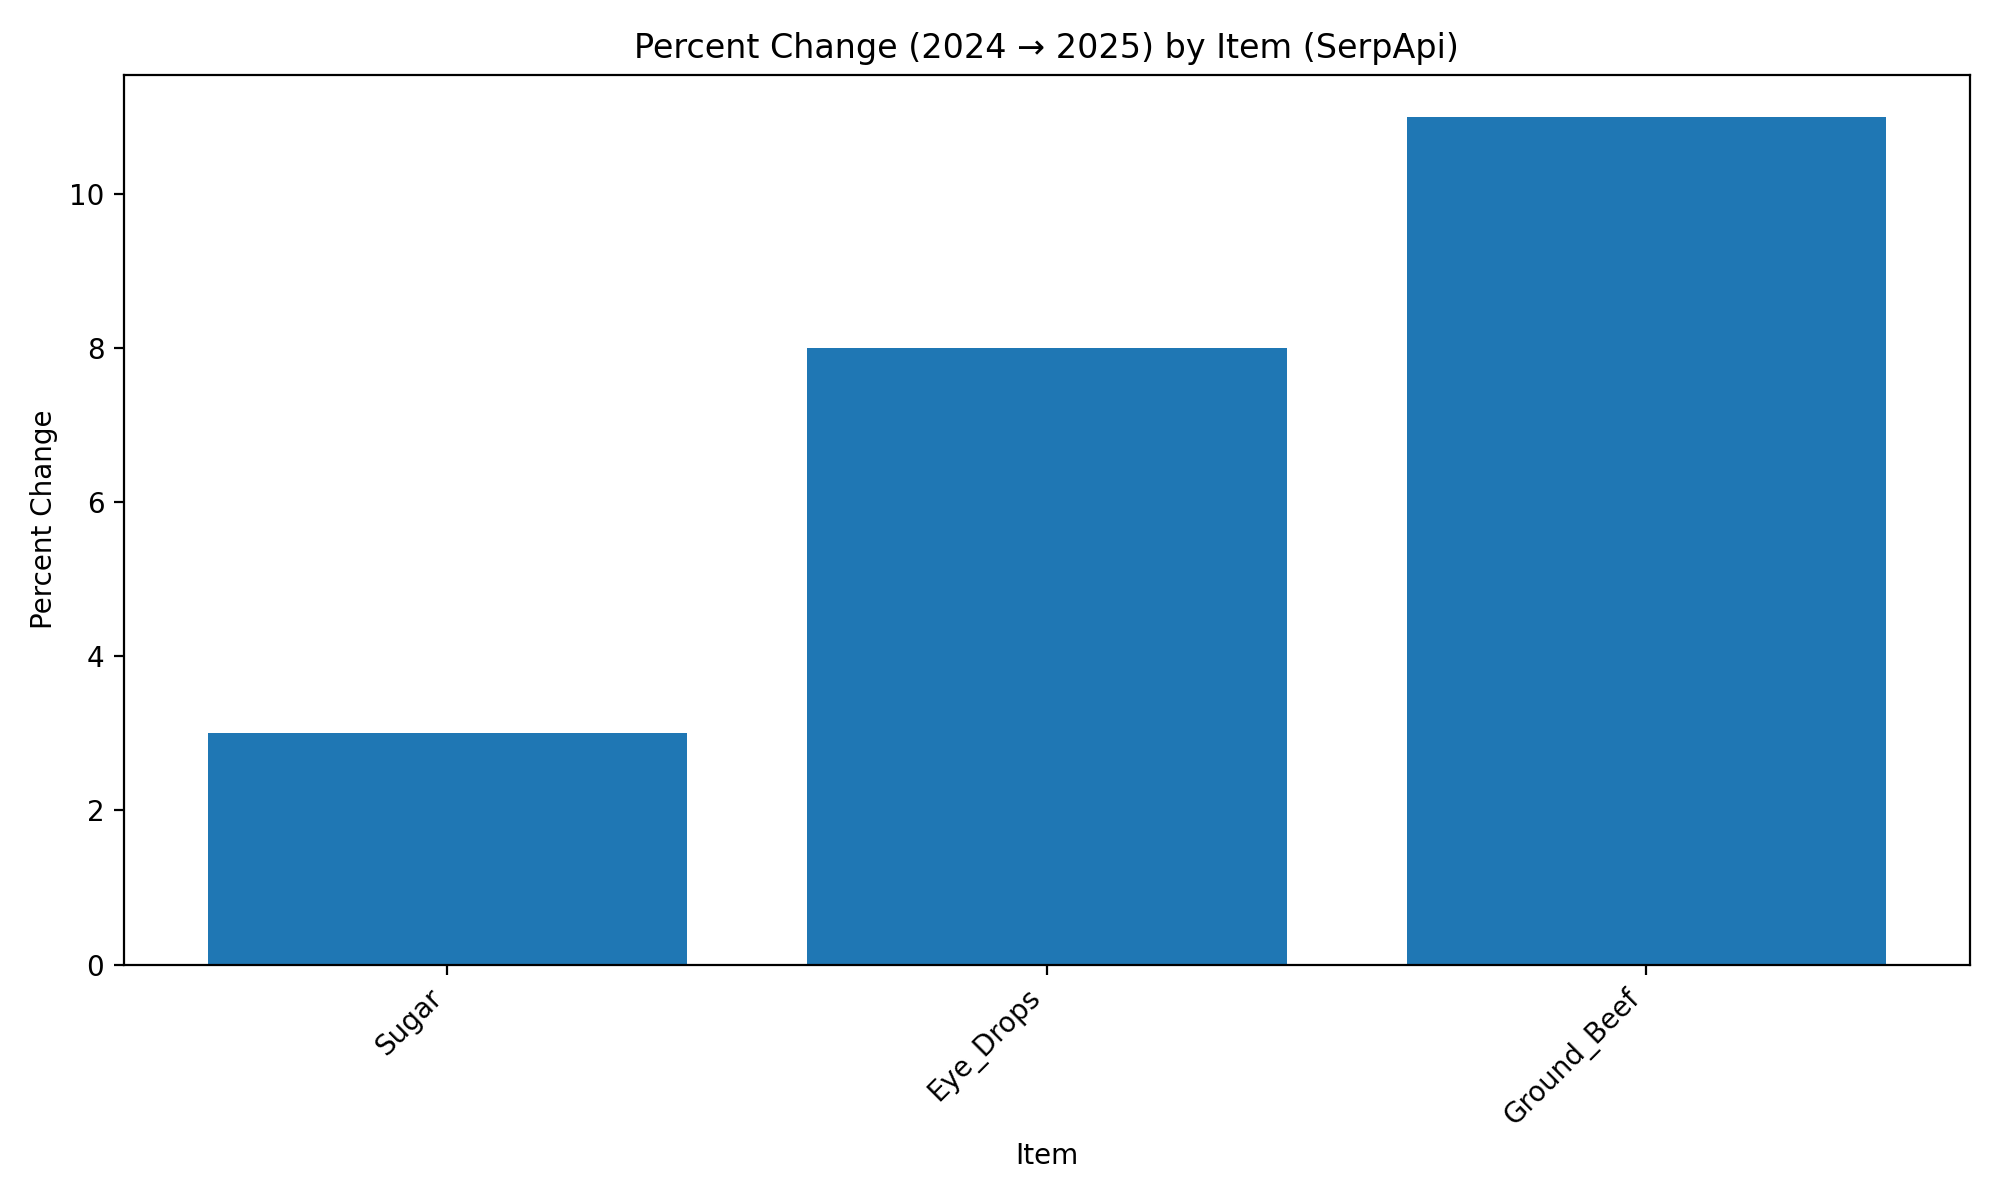

In [48]:
from IPython.display import Image, display

# Display the image in Python
image_path = "/content/The-Cost-of-Democracy/asmaa/plots/serpapi_percent_change_2024_2025.png"
display(Image(filename=image_path))

We can see that the cost of these items has risen since 2024.

# How do those changes in price compare to the previous election cycle?

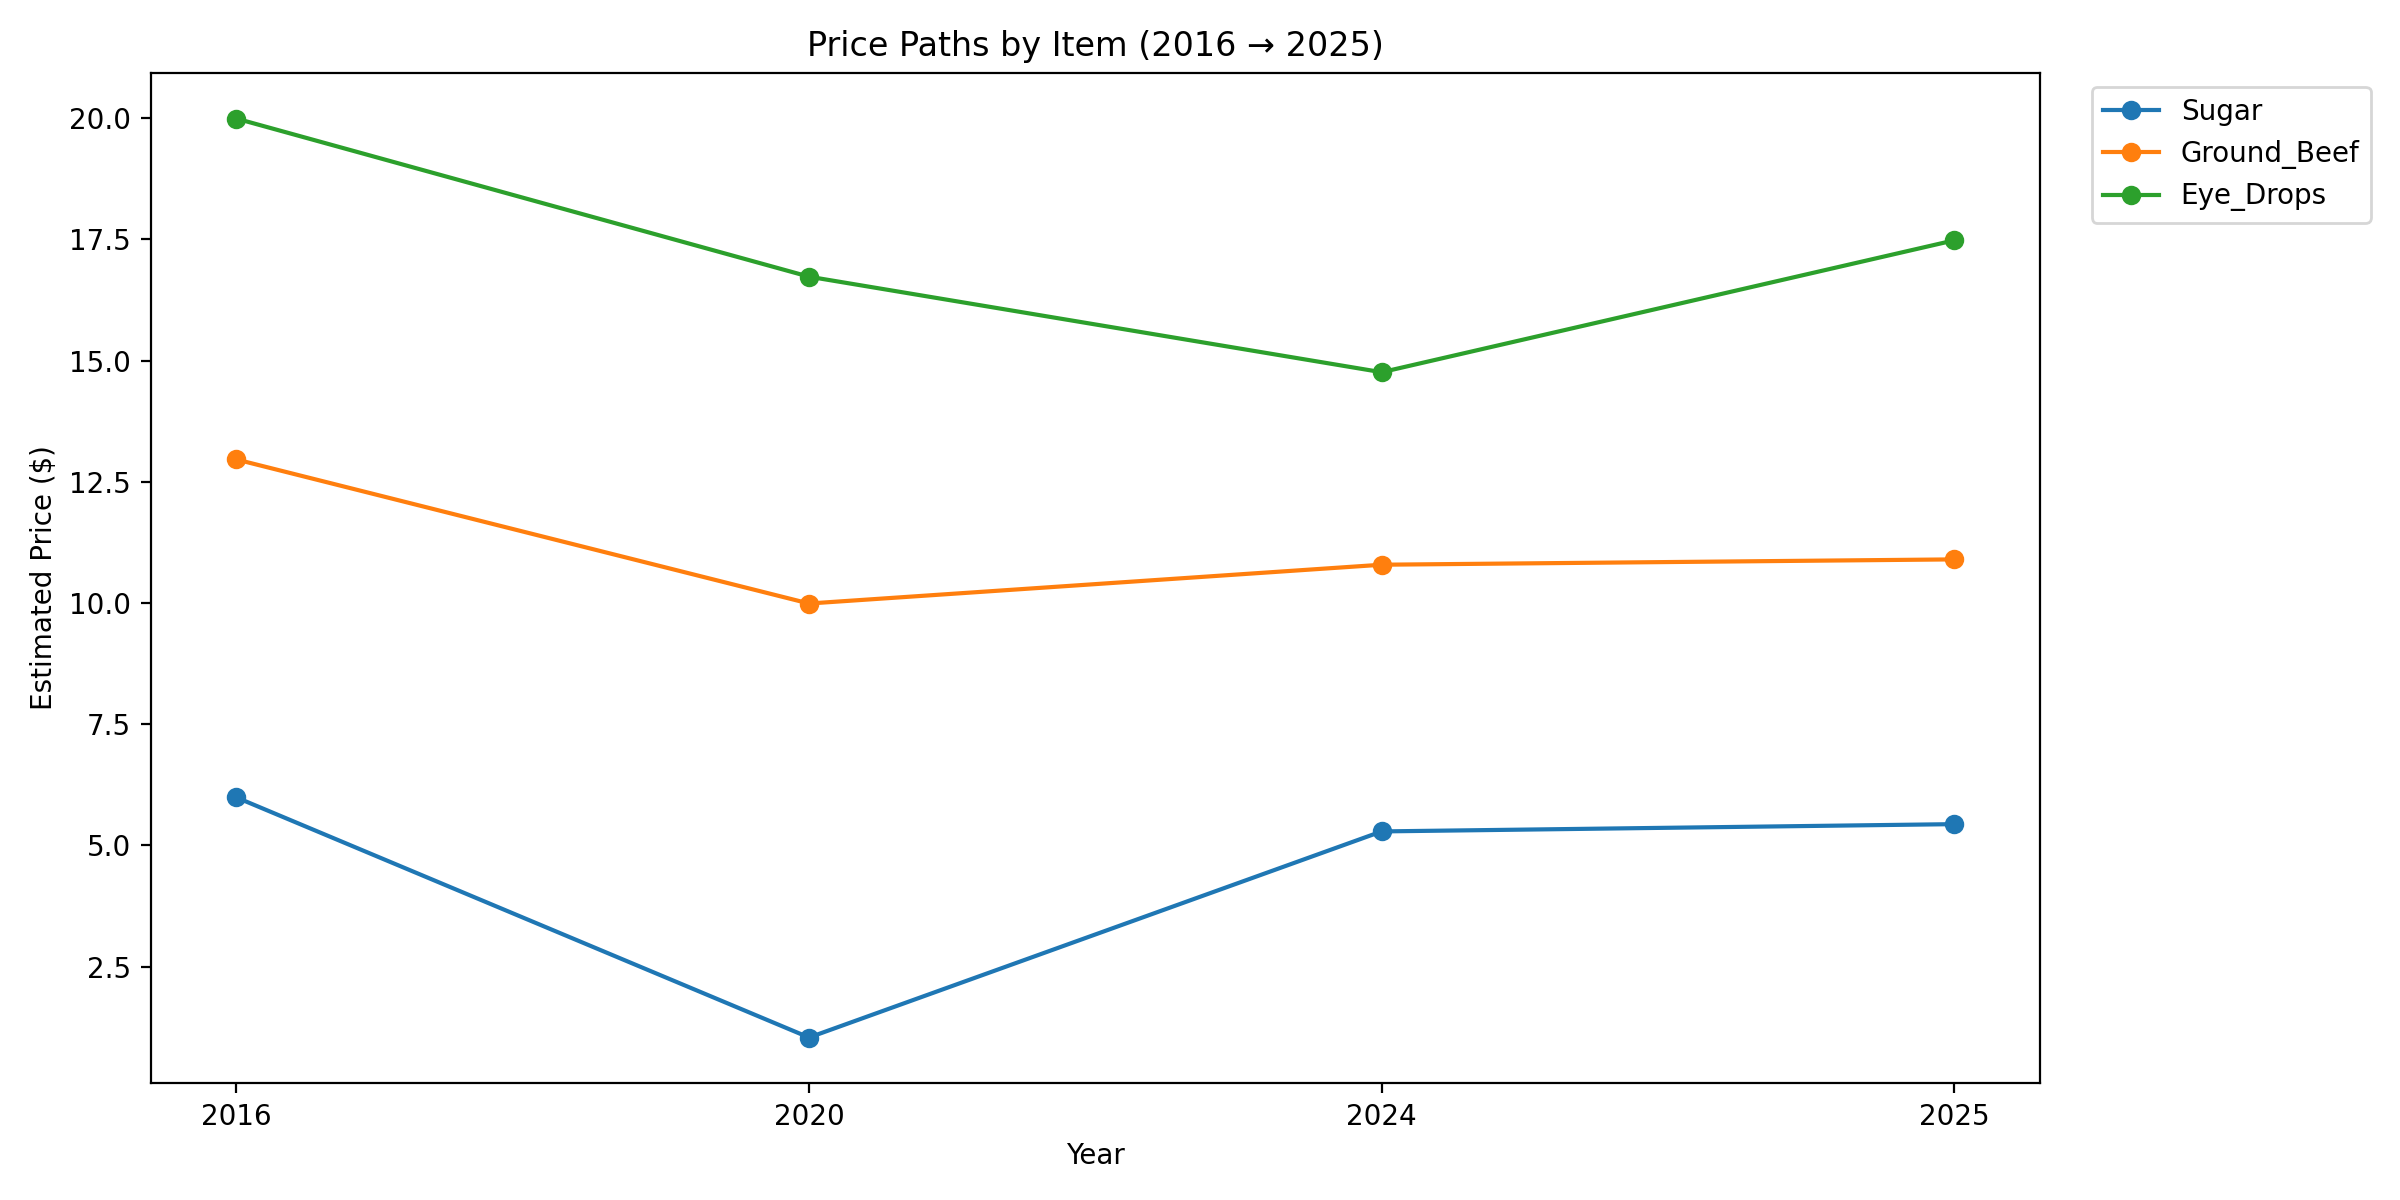

In [44]:
from IPython.display import Image, display

# Display the image in Python
image_path = "/content/The-Cost-of-Democracy/asmaa/plots/serpapi_price_paths_since_2016.png"
display(Image(filename=image_path))


We can see that prices for ground beef and sugar have been steadily rising since 2020 while the price of eye drops sharply rose starting in 2024.